#### **Imports**

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import nltk
import re

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
import warnings 
warnings.filterwarnings("ignore")

#### **Read in dataframe saves as .csv file**

In [11]:
# read in dataframe saved as .csv file
df = pd.read_csv('comments.csv')
# drop first column
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,author,body,score,created_utc,subreddit,body_word_count
0,RobusEtCeleritas,None of that means anything You clearly have ...,3,1627142891,1,11
1,hydroxypcp,The legal limit varies among countries It s c...,0,1627140964,1,130
2,AnthillOmbudsman,But magma chambers aren t hollow caverns I m...,1,1627140360,1,14
3,AWormDude,According to this study https www research...,5,1627139388,1,487
4,Trypanosoma_,Look up TH cellular response vs TH humora...,-4,1627136260,1,57


In [12]:
all_stop_words = stopwords.words('english')
new_words=('https', 'com', 'www', 'really', 'would', 'gt', 'like', 'also', 'get', 'even', 'much', 'could', 'see', 'really', 'know')
for i in new_words:
    all_stop_words.append(i)

##### **X,y, train, test, split**

In [13]:
X = df[['body']]
y = df['subreddit']

X = [word.lower().split() for word in df['body']]
posts_list = []
for post in X:
    meaningful_words = [word for word in post if word not in all_stop_words]
    meaningful_post = " ".join(meaningful_words)
    posts_list.append(meaningful_post)
    
modeltext = pd.Series(posts_list)
df['body'] = modeltext
X = df['body']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,
                                   y,
                                   train_size=0.75,
                                   stratify=y,
                                   random_state=42)

#### **Baseline Accuracy**

In [14]:
y.value_counts(normalize=True)

0    0.699791
1    0.300209
Name: subreddit, dtype: float64

##### **Count Vectorizer, Logistic Regression, GridSearch**

In [30]:
%%time
pipe_logreg = Pipeline([
    ('cv', CountVectorizer(stop_words='english')),
    ('logreg', LogisticRegression())
]
)
params_logreg = {
    'cv__max_features': [3_000, 4_000],
    'cv__min_df'      : [2, 3],
    'cv__max_df'      : [.80, .85],
    'cv__ngram_range' : [(1,1)],
    'logreg__C'       : [0.1, 1.0],
    'logreg__solver'  : ['liblinear'], 
    'logreg__penalty' : ['l1'],
    'logreg__max_iter': [5_000, 6_000, 7_000]
}

gs_logreg = GridSearchCV(pipe_logreg, params_logreg, cv=5, verbose=1, n_jobs = -1)
gs_logreg.fit(X_train, y_train)
print(gs_logreg.best_params_)
print(gs_logreg.score(X_train, y_train))
print(gs_logreg.score(X_test, y_test))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'cv__max_df': 0.8, 'cv__max_features': 4000, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'logreg__C': 1.0, 'logreg__max_iter': 7000, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
0.9237230030853617
0.8717058747911043
Wall time: 1min 3s


In [31]:
cv_preds = gs_logreg.best_estimator_.predict(X_test)
print(f'Best Score: {gs_logreg.best_score_}')
print(f'Accuracy Score: {accuracy_score(y_test, cv_preds)}')

Best Score: 0.8711861106505612
Accuracy Score: 0.8717058747911043


#### **TF-IDF Vectorizer**

In [19]:
%%time
pipe_tv = Pipeline([
    ('tv', TfidfVectorizer(stop_words='english')),
    ('logreg', LogisticRegression())
]
)
params_tv = {
    'tv__max_features':[2000, 4000, 5000],
    'tv__min_df'      : [2, 3],
    'tv__max_df'      : [.80, .85],
    'tv__ngram_range' : [(1,1)],
    'logreg__solver'  : ['liblinear'], 
    'logreg__penalty' : ['l1'],
    'logreg__max_iter': [5_000, 7000]
}

gs_tv = GridSearchCV(pipe_tv, params_tv, cv=5, verbose=1, n_jobs = -1)
gs_tv.fit(X_train, y_train)
print(gs_tv.best_params_)
print(gs_tv.score(X_train, y_train))
print(gs_tv.score(X_test, y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'logreg__max_iter': 7000, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear', 'tv__max_df': 0.85, 'tv__max_features': 4000, 'tv__min_df': 2, 'tv__ngram_range': (1, 1)}
0.8983116215289682
0.8727342846124181
Wall time: 48.8 s


In [32]:
tv_preds = gs_tv.best_estimator_.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, tv_preds)}')

Accuracy Score: 0.8727342846124181


#### **CountVectorizer & Logisitic Regression Confusion Matrix**

In [40]:
cm_cv = confusion_matrix(y_test, cv_preds)
tn, fp, fn, tp = cm_cv.ravel()

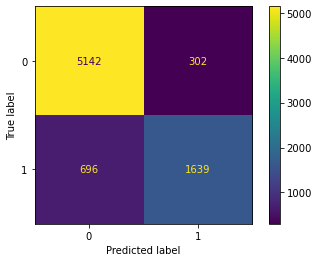

In [41]:
# Plot confusion matrix
ConfusionMatrixDisplay(cm_cv).plot();

#### **TV-IDF Vectorizer & Logistic Regression Confusion Matrix**

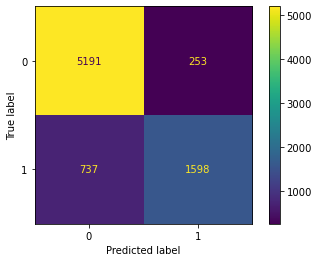

In [44]:
cm_tv = confusion_matrix(y_test, tv_preds)
tn, fp, fn, tp = cm_tv.ravel()
# Plot confusion matrix
ConfusionMatrixDisplay(cm_tv).plot();